In [6]:
import cv2
import numpy as np
from skimage.feature import hog
from scipy.ndimage.measurements import label
from os import walk
from os import path
import time
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import sklearn.preprocessing as preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.externals import joblib
import os
import matplotlib.pyplot as plt
import multiprocessing
import pickle
from copy import copy
import glob
from timeit import default_timer as timer
from IPython.display import HTML
from moviepy.editor import VideoFileClip
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
import time
from multiprocessing import Pool
import matplotlib.image as mpimg
from keras.models import Sequential
from keras.layers import Dense, Dropout, Convolution2D, Flatten, Input, Conv2D, MaxPooling2D, Lambda
from keras import optimizers
from keras.layers.normalization import BatchNormalization
from keras.models import Model
import skimage
from skimage import io,transform 

In [7]:
###split data into train and test data 
def get_file_name(rootDir):
    import os
    data = []
    for root, dirs, files in os.walk(rootDir, topdown=False):
        for name in files:
            _, ending = path.splitext(name)
            if ending != ".jpg" and ending != ".jepg" and ending != ".png":
                continue
            else:
                data.append(path.join(root, name))
    return data
vehicles = get_file_name("data\\vehicles")
not_vehicles = get_file_name("data\\non-vehicles")
X = []
for i in vehicles:
    X.append(skimage.io.imread(i))
for j in not_vehicles:
    X.append(skimage.io.imread(j))
X=np.array(X)

In [44]:
Y=np.concatenate([np.ones(len(vehicles)),np.zeros(len(not_vehicles))])
rate=np.random.randint(0,50)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=rate)
# Show messages
X_train,X_val,Y_train,Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=rate)

In [65]:
def create_model(input_shape=(64,64,3)):
    model = Sequential()
    # Center and normalize our data
    model.add(Lambda(lambda x: x/255.,input_shape=input_shape, output_shape=input_shape))
    # 1st conv layer with 128 filter, 3x3 each, 50% dropout
    model.add(Convolution2D(16, 3, 3, activation='relu', name='conv1',input_shape=input_shape, border_mode="same"))  
    model.add(Dropout(0.2))
    # 2nd conv layer with 128 filter, 3x3 each, 50% dropout
    model.add(Convolution2D(32, 3, 3, activation='relu', name='conv2',border_mode="same"))
    model.add(Dropout(0.2))
    # 3rd conv layer with 128 filter, 3x3 each, 8x8 pooling and dropout
    model.add(MaxPooling2D(pool_size=(8,8)))
    model.add(Dropout(0.5))
    # This acts like a 128 neuron dense layer
    model.add(Convolution2D(1,8,8,activation="sigmoid",name="dense1")) 
    # This is like a 1 neuron dense layer with tanh [-1, 1]
    
    return model

model = create_model()
model.summary()
model.add(Flatten())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_6 (Lambda)            (None, 64, 64, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 16)        448       
_________________________________________________________________
dropout_17 (Dropout)         (None, 64, 64, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 64, 64, 32)        4640      
_________________________________________________________________
dropout_18 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 8, 8, 32)          0         
__________

In [66]:
from keras.callbacks import ModelCheckpoint 
size=64 
n_targets=1 
def generator(train,label,batch_size):
  """Generate batch with respect to array's first axis."""
  start = 0  # pointer to where we are in iteration
  while True:
    stop = start + batch_size
    diff = stop - train.shape[0]
    if diff <= 0:
      train_generator = train[start:stop]
      label_generator = label[start:stop]
      start += batch_size
    else:
       train_generator= np.concatenate((train[start:], train[:diff]))
       label_generator=np.concatenate((label[start:], label[:diff]))
       start = diff
    yield train_generator,label_generator

In [67]:
batch_size=64
start_time = time.time() 
model.compile(loss='mse',optimizer='adam',metrics=['accuracy']) 
hist = model.fit_generator(generator(X_train,Y_train,batch_size),
steps_per_epoch=X_train.shape[0] // batch_size, 
epochs=5, verbose=1, 
validation_data=(X_val, Y_val))
#hist = model.fit(X_train, y_train, batch_size=16, epochs=100, verbose=0, validation_data=(X_test, y_test))
print("--- %s seconds ---" % (time.time() - start_time))
model.save_weights('./deep-model/model2.h5')

Epoch 1/5


215/224 [===========================>..] - ETA: 205s - loss: 0.2714 - acc: 0.468 - ETA: 116s - loss: 0.2652 - acc: 0.460 - ETA: 86s - loss: 0.2604 - acc: 0.515 - ETA: 72s - loss: 0.2567 - acc: 0.53 - ETA: 63s - loss: 0.2544 - acc: 0.55 - ETA: 57s - loss: 0.2553 - acc: 0.53 - ETA: 53s - loss: 0.2520 - acc: 0.54 - ETA: 52s - loss: 0.2504 - acc: 0.56 - ETA: 49s - loss: 0.2478 - acc: 0.57 - ETA: 48s - loss: 0.2478 - acc: 0.56 - ETA: 46s - loss: 0.2461 - acc: 0.56 - ETA: 45s - loss: 0.2452 - acc: 0.56 - ETA: 44s - loss: 0.2457 - acc: 0.56 - ETA: 43s - loss: 0.2438 - acc: 0.57 - ETA: 42s - loss: 0.2420 - acc: 0.58 - ETA: 41s - loss: 0.2425 - acc: 0.57 - ETA: 40s - loss: 0.2419 - acc: 0.56 - ETA: 39s - loss: 0.2406 - acc: 0.57 - ETA: 38s - loss: 0.2399 - acc: 0.58 - ETA: 38s - loss: 0.2387 - acc: 0.59 - ETA: 37s - loss: 0.2376 - acc: 0.59 - ETA: 36s - loss: 0.2360 - acc: 0.60 - ETA: 36s - loss: 0.2342 - acc: 0.61 - ETA: 35s - loss: 0.2329 - acc: 0.62 - ETA: 35s - loss: 0.2327 - acc: 0.62 - ET

224/224 [==============================] - ETA: 1s - loss: 0.1110 - acc: 0.848 - ETA: 0s - loss: 0.1108 - acc: 0.848 - ETA: 0s - loss: 0.1106 - acc: 0.849 - ETA: 0s - loss: 0.1104 - acc: 0.849 - ETA: 0s - loss: 0.1101 - acc: 0.849 - ETA: 0s - loss: 0.1099 - acc: 0.850 - ETA: 0s - loss: 0.1097 - acc: 0.850 - ETA: 0s - loss: 0.1095 - acc: 0.850 - 32s - loss: 0.1092 - acc: 0.8511 - val_loss: 0.0570 - val_acc: 0.9525
Epoch 2/5


215/224 [===========================>..] - ETA: 27s - loss: 0.0615 - acc: 0.92 - ETA: 29s - loss: 0.0603 - acc: 0.93 - ETA: 30s - loss: 0.0578 - acc: 0.93 - ETA: 29s - loss: 0.0631 - acc: 0.92 - ETA: 29s - loss: 0.0618 - acc: 0.92 - ETA: 29s - loss: 0.0589 - acc: 0.93 - ETA: 29s - loss: 0.0576 - acc: 0.93 - ETA: 29s - loss: 0.0594 - acc: 0.93 - ETA: 29s - loss: 0.0571 - acc: 0.93 - ETA: 28s - loss: 0.0562 - acc: 0.93 - ETA: 28s - loss: 0.0559 - acc: 0.93 - ETA: 28s - loss: 0.0556 - acc: 0.93 - ETA: 28s - loss: 0.0537 - acc: 0.94 - ETA: 27s - loss: 0.0529 - acc: 0.94 - ETA: 27s - loss: 0.0534 - acc: 0.93 - ETA: 27s - loss: 0.0525 - acc: 0.93 - ETA: 27s - loss: 0.0519 - acc: 0.93 - ETA: 27s - loss: 0.0532 - acc: 0.93 - ETA: 27s - loss: 0.0529 - acc: 0.93 - ETA: 27s - loss: 0.0539 - acc: 0.93 - ETA: 27s - loss: 0.0529 - acc: 0.93 - ETA: 26s - loss: 0.0530 - acc: 0.93 - ETA: 26s - loss: 0.0536 - acc: 0.93 - ETA: 26s - loss: 0.0537 - acc: 0.93 - ETA: 26s - loss: 0.0535 - acc: 0.93 - ETA: 26

224/224 [==============================] - ETA: 1s - loss: 0.0419 - acc: 0.950 - ETA: 0s - loss: 0.0418 - acc: 0.950 - ETA: 0s - loss: 0.0418 - acc: 0.950 - ETA: 0s - loss: 0.0417 - acc: 0.950 - ETA: 0s - loss: 0.0417 - acc: 0.950 - ETA: 0s - loss: 0.0418 - acc: 0.950 - ETA: 0s - loss: 0.0417 - acc: 0.950 - ETA: 0s - loss: 0.0417 - acc: 0.950 - 30s - loss: 0.0417 - acc: 0.9508 - val_loss: 0.0326 - val_acc: 0.9769
Epoch 3/5


215/224 [===========================>..] - ETA: 28s - loss: 0.0105 - acc: 0.98 - ETA: 28s - loss: 0.0222 - acc: 0.96 - ETA: 28s - loss: 0.0252 - acc: 0.96 - ETA: 28s - loss: 0.0291 - acc: 0.96 - ETA: 28s - loss: 0.0327 - acc: 0.95 - ETA: 27s - loss: 0.0333 - acc: 0.95 - ETA: 27s - loss: 0.0334 - acc: 0.96 - ETA: 27s - loss: 0.0332 - acc: 0.96 - ETA: 27s - loss: 0.0339 - acc: 0.96 - ETA: 27s - loss: 0.0333 - acc: 0.96 - ETA: 27s - loss: 0.0323 - acc: 0.96 - ETA: 27s - loss: 0.0330 - acc: 0.96 - ETA: 27s - loss: 0.0325 - acc: 0.96 - ETA: 27s - loss: 0.0316 - acc: 0.96 - ETA: 27s - loss: 0.0311 - acc: 0.96 - ETA: 27s - loss: 0.0302 - acc: 0.96 - ETA: 27s - loss: 0.0298 - acc: 0.96 - ETA: 27s - loss: 0.0291 - acc: 0.96 - ETA: 27s - loss: 0.0296 - acc: 0.96 - ETA: 26s - loss: 0.0297 - acc: 0.96 - ETA: 26s - loss: 0.0295 - acc: 0.96 - ETA: 26s - loss: 0.0295 - acc: 0.96 - ETA: 26s - loss: 0.0293 - acc: 0.96 - ETA: 26s - loss: 0.0294 - acc: 0.96 - ETA: 26s - loss: 0.0288 - acc: 0.97 - ETA: 26

224/224 [==============================] - ETA: 1s - loss: 0.0270 - acc: 0.969 - ETA: 0s - loss: 0.0269 - acc: 0.969 - ETA: 0s - loss: 0.0269 - acc: 0.969 - ETA: 0s - loss: 0.0269 - acc: 0.969 - ETA: 0s - loss: 0.0269 - acc: 0.969 - ETA: 0s - loss: 0.0269 - acc: 0.969 - ETA: 0s - loss: 0.0269 - acc: 0.969 - ETA: 0s - loss: 0.0269 - acc: 0.969 - 30s - loss: 0.0269 - acc: 0.9697 - val_loss: 0.0235 - val_acc: 0.9800
Epoch 4/5


215/224 [===========================>..] - ETA: 28s - loss: 0.0332 - acc: 0.96 - ETA: 27s - loss: 0.0218 - acc: 0.97 - ETA: 28s - loss: 0.0236 - acc: 0.97 - ETA: 28s - loss: 0.0200 - acc: 0.98 - ETA: 28s - loss: 0.0179 - acc: 0.98 - ETA: 27s - loss: 0.0229 - acc: 0.97 - ETA: 27s - loss: 0.0225 - acc: 0.97 - ETA: 27s - loss: 0.0223 - acc: 0.98 - ETA: 27s - loss: 0.0241 - acc: 0.97 - ETA: 27s - loss: 0.0232 - acc: 0.97 - ETA: 27s - loss: 0.0236 - acc: 0.97 - ETA: 27s - loss: 0.0238 - acc: 0.97 - ETA: 27s - loss: 0.0233 - acc: 0.97 - ETA: 27s - loss: 0.0233 - acc: 0.97 - ETA: 27s - loss: 0.0227 - acc: 0.97 - ETA: 27s - loss: 0.0235 - acc: 0.97 - ETA: 27s - loss: 0.0229 - acc: 0.97 - ETA: 27s - loss: 0.0230 - acc: 0.97 - ETA: 26s - loss: 0.0225 - acc: 0.97 - ETA: 26s - loss: 0.0233 - acc: 0.97 - ETA: 26s - loss: 0.0235 - acc: 0.97 - ETA: 26s - loss: 0.0235 - acc: 0.97 - ETA: 26s - loss: 0.0232 - acc: 0.97 - ETA: 26s - loss: 0.0230 - acc: 0.97 - ETA: 26s - loss: 0.0223 - acc: 0.97 - ETA: 25

224/224 [==============================] - ETA: 1s - loss: 0.0216 - acc: 0.974 - ETA: 0s - loss: 0.0215 - acc: 0.974 - ETA: 0s - loss: 0.0214 - acc: 0.975 - ETA: 0s - loss: 0.0214 - acc: 0.975 - ETA: 0s - loss: 0.0214 - acc: 0.975 - ETA: 0s - loss: 0.0215 - acc: 0.974 - ETA: 0s - loss: 0.0215 - acc: 0.974 - ETA: 0s - loss: 0.0214 - acc: 0.975 - 30s - loss: 0.0214 - acc: 0.9750 - val_loss: 0.0185 - val_acc: 0.9837
Epoch 5/5


215/224 [===========================>..] - ETA: 27s - loss: 0.0117 - acc: 0.98 - ETA: 27s - loss: 0.0115 - acc: 0.98 - ETA: 27s - loss: 0.0147 - acc: 0.97 - ETA: 27s - loss: 0.0184 - acc: 0.97 - ETA: 27s - loss: 0.0166 - acc: 0.97 - ETA: 27s - loss: 0.0177 - acc: 0.97 - ETA: 27s - loss: 0.0202 - acc: 0.97 - ETA: 27s - loss: 0.0193 - acc: 0.98 - ETA: 27s - loss: 0.0185 - acc: 0.98 - ETA: 27s - loss: 0.0192 - acc: 0.98 - ETA: 27s - loss: 0.0191 - acc: 0.98 - ETA: 27s - loss: 0.0188 - acc: 0.98 - ETA: 27s - loss: 0.0188 - acc: 0.98 - ETA: 26s - loss: 0.0186 - acc: 0.98 - ETA: 26s - loss: 0.0187 - acc: 0.98 - ETA: 26s - loss: 0.0184 - acc: 0.98 - ETA: 26s - loss: 0.0184 - acc: 0.98 - ETA: 26s - loss: 0.0195 - acc: 0.97 - ETA: 26s - loss: 0.0190 - acc: 0.97 - ETA: 26s - loss: 0.0188 - acc: 0.97 - ETA: 26s - loss: 0.0189 - acc: 0.97 - ETA: 26s - loss: 0.0185 - acc: 0.98 - ETA: 25s - loss: 0.0187 - acc: 0.97 - ETA: 25s - loss: 0.0183 - acc: 0.97 - ETA: 25s - loss: 0.0182 - acc: 0.98 - ETA: 25

224/224 [==============================] - ETA: 1s - loss: 0.0171 - acc: 0.980 - ETA: 0s - loss: 0.0171 - acc: 0.980 - ETA: 0s - loss: 0.0172 - acc: 0.980 - ETA: 0s - loss: 0.0171 - acc: 0.980 - ETA: 0s - loss: 0.0171 - acc: 0.980 - ETA: 0s - loss: 0.0171 - acc: 0.980 - ETA: 0s - loss: 0.0171 - acc: 0.980 - ETA: 0s - loss: 0.0171 - acc: 0.980 - 30s - loss: 0.0171 - acc: 0.9807 - val_loss: 0.0150 - val_acc: 0.9894
--- 154.22204279899597 seconds ---


In [68]:
accuracy=model.evaluate_generator(generator=generator(X_test,Y_test,batch_size),steps=X_test.shape[0]//batch_size)

In [69]:
print("test accuracy:",accuracy[1])

test accuracy: 0.990162037037


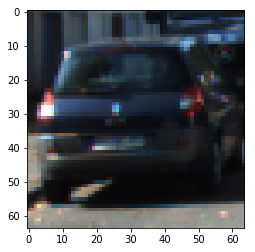

In [86]:
##
rand = np.random.randint(X_test.shape[0])
plt.imshow(X_test[rand])
plt.show()

In [87]:
sample = np.reshape(X_test[rand], (1, 64,64,3))
prediction = model.predict(sample, batch_size=64, verbose=0)
if prediction[0][0]<0.5:
    print("not car,truth:",Y_test[rand])
else:
    print("car,truth:",Y_test[rand])

car,truth: 1.0


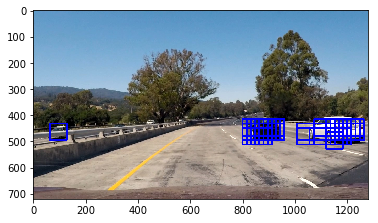

In [106]:
##use slide window 
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                 xy_window=(64, 64), xy_overlap=(0.75, 0.75)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0] * (1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1] * (1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0] * (xy_overlap[0]))
    ny_buffer = np.int(xy_window[1] * (xy_overlap[1]))
    nx_windows = np.int((xspan - nx_buffer) / nx_pix_per_step)
    ny_windows = np.int((yspan - ny_buffer) / ny_pix_per_step)
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs * nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys * ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            if starty > 400 and endy <= 600:
                window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list
def search_windows(img, windows):
    # 1) Create an empty list to receive positive detection windows
    on_windows = []
    # 2) Iterate over all windows in the list
    for window in windows:
        # 3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        sample = np.reshape(test_img, (1, 64,64,3))
        prediction = model.predict(sample, batch_size=64, verbose=0)
        if prediction[0][0]>0.5:
            on_windows.append(window)
    return on_windows
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
test_img = mpimg.imread("./test_images/test1.jpg")
windows = slide_window(img=test_img)
on_windows=search_windows(test_img,windows)
draw_img=draw_boxes(test_img,on_windows)
plt.imshow(draw_img)
plt.show()

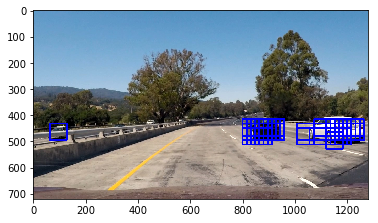

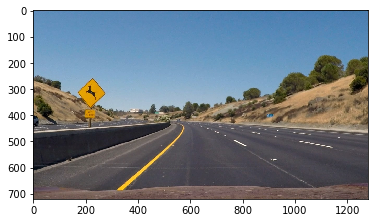

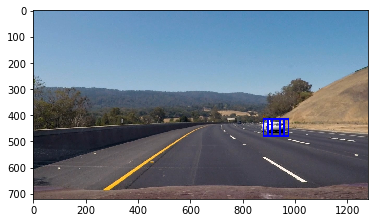

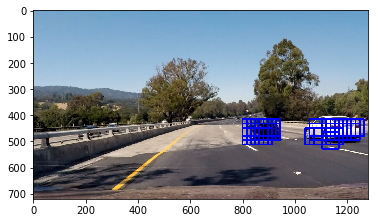

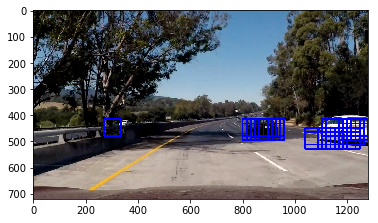

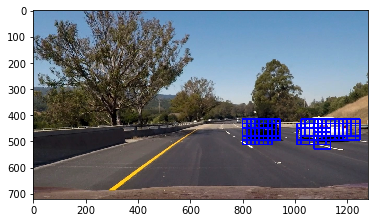

In [125]:
test_img_paths = glob.glob("./test_images/*.jpg")
for path in test_img_paths:
    test_img=mpimg.imread(path)
    windows = slide_window(img=test_img)
    on_windows=search_windows(test_img,windows)
    draw_img=draw_boxes(test_img,on_windows)
    plt.imshow(draw_img)
    plt.imsave("./output_images/cnn/"+path.split("\\")[1],draw_img)
    plt.show()

In [126]:
##add heat and apply_threshold if need and draw label
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Return updated heatmap
    return heatmap  # Iterate through list of bboxes


def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1] + 1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 255), 6)
    # Return the image
    return img

In [131]:
def get_label_box(image,on_windows):
    heat = np.zeros_like(image[:, :, 0]).astype(np.float)
    heat = add_heat(heat, on_windows)
    # Apply threshold to help remove false positives
    plt.imshow(heat)
    plt.show()
    heat = apply_threshold(heat, 2)
    # Visualize the heatmap when displaying
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img

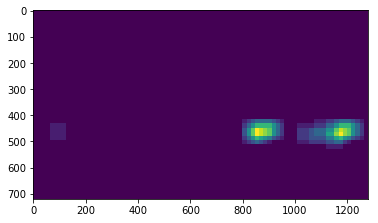

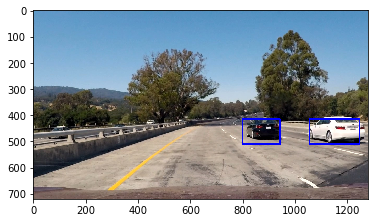

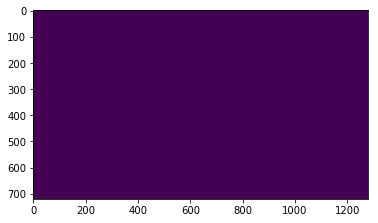

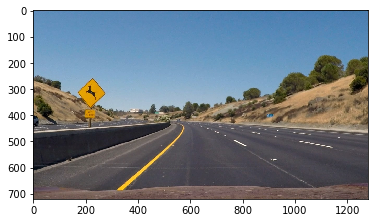

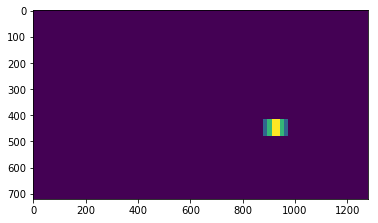

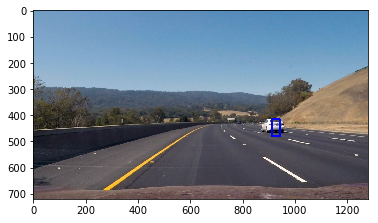

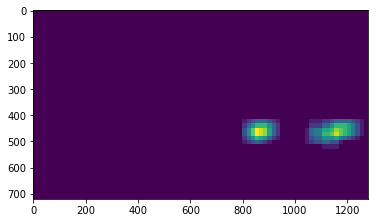

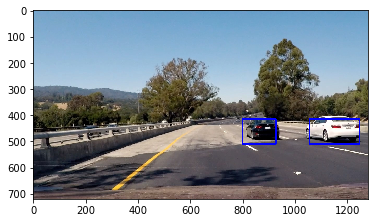

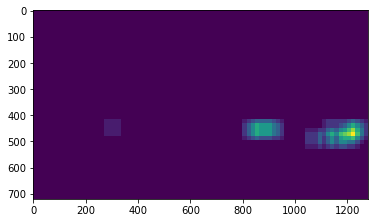

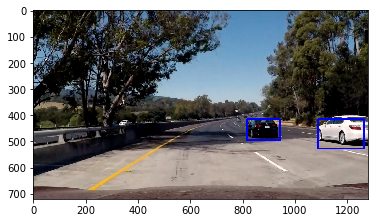

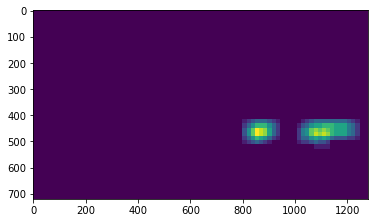

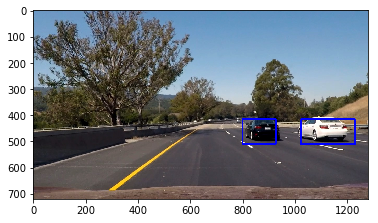

In [132]:
for path in test_img_paths:
    test_img=mpimg.imread(path)
    windows = slide_window(img=test_img)
    on_windows=search_windows(test_img,windows)
    draw_img=get_label_box(test_img,on_windows)
    plt.imshow(draw_img)
    plt.show()

In [121]:
##all above examples show that the method is doing well.
def process(img):
    windows = slide_window(img)
    on_windows=search_windows(img,windows)
    draw_img=get_label_box(img,on_windows)
    return draw_img
video_test_output = "video_out/test_video.mp4"
clip_test = VideoFileClip("test_video.mp4")
clip_output = clip_test.fl_image(process)  # NOTE: this function expects color images!!
clip_output.write_videofile(video_test_output, audio=False)

[MoviePy] >>>> Building video video_out/test_video.mp4
[MoviePy] Writing video video_out/test_video.mp4


 97%|█████████▋| 38/39 [00:59<00:01,  1.46s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video_out/test_video.mp4 



In [122]:
video_project_output = "video_out/project_video.mp4"
clip_project = VideoFileClip("project_video.mp4")
clip_project_output = clip_project.fl_image(process)  # NOTE: this function expects color images!!
clip_project_output.write_videofile(video_project_output, audio=False)

[MoviePy] >>>> Building video video_out/project_video.mp4
[MoviePy] Writing video video_out/project_video.mp4


100%|█████████▉| 1260/1261 [31:09<00:01,  1.57s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video_out/project_video.mp4 



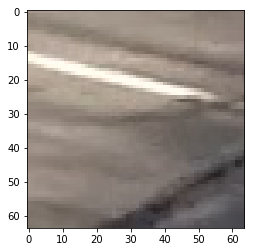

array([ 1.,  1.,  0., ...,  1.,  0.,  0.])